# Distort character images

Program works by loading images from their respective folders in the central data store, applying specified distortions to reduce the quality and then saving the image back to the correct folder.

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import os
from wand.api import library
import wand.color
import wand.image
import numpy as np
from skimage import measure
from PIL import Image
from scipy import ndimage
import random

data_dir = './source'
img_filetype = '.png'

# The range of characters to distort
char_from = 1
char_to = 1076

In [7]:
# Param: file - the filename of the image e.g. 1_1, 3_10, 150_2 etc.
# Returns image as numpy array
def load_image(file):
    img_folder = file[0:file.index('_')]
    img = Image.open(os.path.join(data_dir, img_folder, file)+img_filetype).convert('L')
    
    im = np.asarray(img)
        
    return im

# im = load_image('1_1')
# print(im.shape)
# plt.imshow(im, cmap='gray')
# plt.show()

In [8]:
def resize_all_images():
    for root, dirs, files in os.walk(data_dir):
        for name in files:
            if '.png' in name:
#                 print(name[:name.index(".")])
                im = load_image(name[:name.index(".")])
                resized_image = pad_image((512,512), im.shape, im)
                plt.imsave(os.path.join(root, name), resized_image, cmap='gray')
                print(f'Saved resized image at {os.path.join(root, name)}')
                
def binarise_image(im, thresh):
    idx = (im < thresh)
    
    binary_im = np.zeros(im.shape, dtype='int')
    
    binary_im[idx] = 255
    binary_im[~idx] = 0
    
    return binary_im

def extract_character(im):
    binary_im = binarise_image(im, 200) # Input images should be black & white anyway, so 128 is arbitrary

    # threshold at 200
    threshed = np.zeros(im.shape, 'int')
    threshed[im<200] = 1
    
    comps = measure.label(threshed, background=0)
    
    component_map, labels = comps, np.unique(comps)

    min_x = im.shape[0]
    min_y = im.shape[1]
    max_x = 0
    max_y = 0
    for label in labels[1:]:
        char_box = char_bounding_box(component_map, label)
        min_x = np.min(np.array([min_x, char_box[0]]))
        min_y = np.min(np.array([min_y, char_box[1]]))
        max_x = np.max(np.array([max_x, char_box[2]]))
        max_y = np.max(np.array([max_y, char_box[3]]))

    extracted_char = np.array(im[min_y:max_y, min_x:max_x])

    return extracted_char
    
# find the coordinate bounding box of a given label in a components image
def char_bounding_box(comps, label=1):
    
    # array of image coordinates in x and y
    xx, yy = np.meshgrid(np.arange(0,comps.shape[1]), np.arange(0,comps.shape[0]))

    # mask/select by where value is given label (component)
    where_x = xx[comps==label]
    where_y = yy[comps==label]
    
    # find min and max extents of coordinates
    return np.min(where_x), np.min(where_y), np.max(where_x), np.max(where_y)   

# Return image im with size shape_from after padding with 255 (white) to size shape_to
def pad_image(shape_to, shape_from, im):
    # Amount of pixels to pad before and after rotated image in x and y directions, to return to original size
    pad_x = int(np.ceil((shape_to[1]-shape_from[1])/2))
    pad_y = int(np.ceil((shape_to[0]-shape_from[0])/2))
    
    padded_image = np.pad(im, ((500,500),(500,500)), 'constant', constant_values=(255))

#     print(padded_image.shape[0]//2-shape_to[0]//2,padded_image.shape[0]//2+shape_to[0]//2)
    cropped_image = padded_image[padded_image.shape[0]//2-shape_to[0]//2:padded_image.shape[0]//2+shape_to[0]//2, padded_image.shape[1]//2-shape_to[1]//2:padded_image.shape[1]//2+shape_to[1]//2]
    
    return cropped_image

In [53]:
resize_all_images()

1_1
484 996
Saved resized image at ./source\1\1_1.png
1_2
500 1012
Saved resized image at ./source\1\1_2.png
1000_1
484 996
Saved resized image at ./source\1000\1000_1.png
1000_2
500 1012
Saved resized image at ./source\1000\1000_2.png
1001_1
484 996
Saved resized image at ./source\1001\1001_1.png
1001_2
285 797
Saved resized image at ./source\1001\1001_2.png
1001_3
285 797
Saved resized image at ./source\1001\1001_3.png
1002_1
484 996
Saved resized image at ./source\1002\1002_1.png
1002_2
283 795
Saved resized image at ./source\1002\1002_2.png
1002_3
283 795
Saved resized image at ./source\1002\1002_3.png
1003_1
484 996
Saved resized image at ./source\1003\1003_1.png
1003_2
484 996
Saved resized image at ./source\1003\1003_2.png
1004_1
484 996
Saved resized image at ./source\1004\1004_1.png
1004_2
500 1012
Saved resized image at ./source\1004\1004_2.png
1005_1
484 996
Saved resized image at ./source\1005\1005_1.png
1005_2
500 1012
Saved resized image at ./source\1005\1005_2.png
1006_1

Saved resized image at ./source\1061\1061_2.png
1062_1
484 996
Saved resized image at ./source\1062\1062_1.png
1062_2
500 1012
Saved resized image at ./source\1062\1062_2.png
1063_1
484 996
Saved resized image at ./source\1063\1063_1.png
1063_2
500 1012
Saved resized image at ./source\1063\1063_2.png
1064_1
484 996
Saved resized image at ./source\1064\1064_1.png
1064_2
500 1012
Saved resized image at ./source\1064\1064_2.png
1066_1
484 996
Saved resized image at ./source\1066\1066_1.png
1066_2
500 1012
Saved resized image at ./source\1066\1066_2.png
1067_1
484 996
Saved resized image at ./source\1067\1067_1.png
1067_2
500 1012
Saved resized image at ./source\1067\1067_2.png
1069_1
484 996
Saved resized image at ./source\1069\1069_1.png
1069_2
484 996
Saved resized image at ./source\1069\1069_2.png
107_1
484 996
Saved resized image at ./source\107\107_1.png
107_2
599 1111
Saved resized image at ./source\107\107_2.png
1071_1
484 996
Saved resized image at ./source\1071\1071_1.png
1071_2


Saved resized image at ./source\162\162_1.png
162_2
500 1012
Saved resized image at ./source\162\162_2.png
164_1
484 996
Saved resized image at ./source\164\164_1.png
164_2
500 1012
Saved resized image at ./source\164\164_2.png
165_1
484 996
Saved resized image at ./source\165\165_1.png
165_2
500 1012
Saved resized image at ./source\165\165_2.png
166_1
484 996
Saved resized image at ./source\166\166_1.png
166_2
500 1012
Saved resized image at ./source\166\166_2.png
167_1
484 996
Saved resized image at ./source\167\167_1.png
167_2
500 1012
Saved resized image at ./source\167\167_2.png
168_1
484 996
Saved resized image at ./source\168\168_1.png
168_2
484 996
Saved resized image at ./source\168\168_2.png
169_1
484 996
Saved resized image at ./source\169\169_1.png
169_2
500 1012
Saved resized image at ./source\169\169_2.png
17_1
484 996
Saved resized image at ./source\17\17_1.png
17_2
500 1012
Saved resized image at ./source\17\17_2.png
170_1
484 996
Saved resized image at ./source\170\170

Saved resized image at ./source\234\234_2.png
235_1
484 996
Saved resized image at ./source\235\235_1.png
235_2
484 996
Saved resized image at ./source\235\235_2.png
236_1
484 996
Saved resized image at ./source\236\236_1.png
236_2
500 1012
Saved resized image at ./source\236\236_2.png
238_1
484 996
Saved resized image at ./source\238\238_1.png
238_2
500 1012
Saved resized image at ./source\238\238_2.png
24_1
484 996
Saved resized image at ./source\24\24_1.png
24_2
500 1012
Saved resized image at ./source\24\24_2.png
240_1
484 996
Saved resized image at ./source\240\240_1.png
240_2
500 1012
Saved resized image at ./source\240\240_2.png
241_1
484 996
Saved resized image at ./source\241\241_1.png
241_2
484 996
Saved resized image at ./source\241\241_2.png
242_1
484 996
Saved resized image at ./source\242\242_1.png
242_2
484 996
Saved resized image at ./source\242\242_2.png
243_1
484 996
Saved resized image at ./source\243\243_1.png
243_2
500 1012
Saved resized image at ./source\243\243_2

Saved resized image at ./source\306\306_1.png
306_2
484 996
Saved resized image at ./source\306\306_2.png
307_1
484 996
Saved resized image at ./source\307\307_1.png
307_2
500 1012
Saved resized image at ./source\307\307_2.png
308_1
484 996
Saved resized image at ./source\308\308_1.png
308_2
525 1037
Saved resized image at ./source\308\308_2.png
309_1
484 996
Saved resized image at ./source\309\309_1.png
309_2
484 996
Saved resized image at ./source\309\309_2.png
31_1
484 996
Saved resized image at ./source\31\31_1.png
31_2
500 1012
Saved resized image at ./source\31\31_2.png
311_1
484 996
Saved resized image at ./source\311\311_1.png
311_2
500 1012
Saved resized image at ./source\311\311_2.png
314_1
484 996
Saved resized image at ./source\314\314_1.png
314_2
605 1117
Saved resized image at ./source\314\314_2.png
315_1
484 996
Saved resized image at ./source\315\315_1.png
315_2
500 1012
Saved resized image at ./source\315\315_2.png
316_1
484 996
Saved resized image at ./source\316\316_

500 1012
Saved resized image at ./source\372\372_2.png
373_1
484 996
Saved resized image at ./source\373\373_1.png
373_2
484 996
Saved resized image at ./source\373\373_2.png
374_1
484 996
Saved resized image at ./source\374\374_1.png
374_2
500 1012
Saved resized image at ./source\374\374_2.png
375_1
484 996
Saved resized image at ./source\375\375_1.png
375_2
500 1012
Saved resized image at ./source\375\375_2.png
376_1
484 996
Saved resized image at ./source\376\376_1.png
376_2
500 1012
Saved resized image at ./source\376\376_2.png
377_1
484 996
Saved resized image at ./source\377\377_1.png
377_2
500 1012
Saved resized image at ./source\377\377_2.png
378_1
484 996
Saved resized image at ./source\378\378_1.png
378_2
500 1012
Saved resized image at ./source\378\378_2.png
379_1
484 996
Saved resized image at ./source\379\379_1.png
379_2
500 1012
Saved resized image at ./source\379\379_2.png
38_1
484 996
Saved resized image at ./source\38\38_1.png
38_2
500 1012
Saved resized image at ./sou

Saved resized image at ./source\437\437_2.png
438_1
484 996
Saved resized image at ./source\438\438_1.png
438_2
500 1012
Saved resized image at ./source\438\438_2.png
439_1
484 996
Saved resized image at ./source\439\439_1.png
439_2
500 1012
Saved resized image at ./source\439\439_2.png
440_1
484 996
Saved resized image at ./source\440\440_1.png
440_2
484 996
Saved resized image at ./source\440\440_2.png
441_1
484 996
Saved resized image at ./source\441\441_1.png
441_2
484 996
Saved resized image at ./source\441\441_2.png
442_1
484 996
Saved resized image at ./source\442\442_1.png
442_2
484 996
Saved resized image at ./source\442\442_2.png
443_1
484 996
Saved resized image at ./source\443\443_1.png
443_2
500 1012
Saved resized image at ./source\443\443_2.png
444_1
484 996
Saved resized image at ./source\444\444_1.png
444_2
500 1012
Saved resized image at ./source\444\444_2.png
445_1
484 996
Saved resized image at ./source\445\445_1.png
445_2
500 1012
Saved resized image at ./source\445

500 1012
Saved resized image at ./source\505\505_2.png
506_1
484 996
Saved resized image at ./source\506\506_1.png
506_2
500 1012
Saved resized image at ./source\506\506_2.png
507_1
484 996
Saved resized image at ./source\507\507_1.png
507_2
500 1012
Saved resized image at ./source\507\507_2.png
508_1
484 996
Saved resized image at ./source\508\508_1.png
508_2
500 1012
Saved resized image at ./source\508\508_2.png
509_1
484 996
Saved resized image at ./source\509\509_1.png
509_2
484 996
Saved resized image at ./source\509\509_2.png
510_1
484 996
Saved resized image at ./source\510\510_1.png
510_2
484 996
Saved resized image at ./source\510\510_2.png
511_1
484 996
Saved resized image at ./source\511\511_1.png
511_2
500 1012
Saved resized image at ./source\511\511_2.png
512_1
484 996
Saved resized image at ./source\512\512_1.png
512_2
500 1012
Saved resized image at ./source\512\512_2.png
513_1
484 996
Saved resized image at ./source\513\513_1.png
513_2
500 1012
Saved resized image at ./

Saved resized image at ./source\573\573_2.png
574_1
484 996
Saved resized image at ./source\574\574_1.png
574_2
596 1108
Saved resized image at ./source\574\574_2.png
575_1
484 996
Saved resized image at ./source\575\575_1.png
575_2
500 1012
Saved resized image at ./source\575\575_2.png
576_1
484 996
Saved resized image at ./source\576\576_1.png
576_2
500 1012
Saved resized image at ./source\576\576_2.png
578_1
484 996
Saved resized image at ./source\578\578_1.png
578_2
500 1012
Saved resized image at ./source\578\578_2.png
579_1
484 996
Saved resized image at ./source\579\579_1.png
579_2
484 996
Saved resized image at ./source\579\579_2.png
58_1
484 996
Saved resized image at ./source\58\58_1.png
58_2
500 1012
Saved resized image at ./source\58\58_2.png
580_1
484 996
Saved resized image at ./source\580\580_1.png
580_2
484 996
Saved resized image at ./source\580\580_2.png
581_1
484 996
Saved resized image at ./source\581\581_1.png
581_2
500 1012
Saved resized image at ./source\581\581_

Saved resized image at ./source\638\638_2.png
639_1
484 996
Saved resized image at ./source\639\639_1.png
639_2
500 1012
Saved resized image at ./source\639\639_2.png
64_1
484 996
Saved resized image at ./source\64\64_1.png
64_2
484 996
Saved resized image at ./source\64\64_2.png
640_1
484 996
Saved resized image at ./source\640\640_1.png
640_2
500 1012
Saved resized image at ./source\640\640_2.png
641_1
484 996
Saved resized image at ./source\641\641_1.png
641_2
500 1012
Saved resized image at ./source\641\641_2.png
642_1
484 996
Saved resized image at ./source\642\642_1.png
642_2
500 1012
Saved resized image at ./source\642\642_2.png
643_1
484 996
Saved resized image at ./source\643\643_1.png
643_2
500 1012
Saved resized image at ./source\643\643_2.png
644_1
484 996
Saved resized image at ./source\644\644_1.png
644_2
500 1012
Saved resized image at ./source\644\644_2.png
645_1
484 996
Saved resized image at ./source\645\645_1.png
645_2
500 1012
Saved resized image at ./source\645\645

Saved resized image at ./source\707\707_2.png
708_1
484 996
Saved resized image at ./source\708\708_1.png
708_2
484 996
Saved resized image at ./source\708\708_2.png
708_3
484 996
Saved resized image at ./source\708\708_3.png
709_1
484 996
Saved resized image at ./source\709\709_1.png
709_2
667 1179
Saved resized image at ./source\709\709_2.png
71_1
484 996
Saved resized image at ./source\71\71_1.png
71_2
500 1012
Saved resized image at ./source\71\71_2.png
710_1
484 996
Saved resized image at ./source\710\710_1.png
710_2
500 1012
Saved resized image at ./source\710\710_2.png
711_1
484 996
Saved resized image at ./source\711\711_1.png
711_2
500 1012
Saved resized image at ./source\711\711_2.png
712_1
484 996
Saved resized image at ./source\712\712_1.png
712_2
500 1012
Saved resized image at ./source\712\712_2.png
713_1
484 996
Saved resized image at ./source\713\713_1.png
713_2
500 1012
Saved resized image at ./source\713\713_2.png
714_1
484 996
Saved resized image at ./source\714\714_

Saved resized image at ./source\781\781_2.png
782_1
484 996
Saved resized image at ./source\782\782_1.png
782_2
500 1012
Saved resized image at ./source\782\782_2.png
783_1
484 996
Saved resized image at ./source\783\783_1.png
783_2
500 1012
Saved resized image at ./source\783\783_2.png
784_1
484 996
Saved resized image at ./source\784\784_1.png
784_2
500 1012
Saved resized image at ./source\784\784_2.png
785_1
484 996
Saved resized image at ./source\785\785_1.png
785_2
500 1012
Saved resized image at ./source\785\785_2.png
786_1
484 996
Saved resized image at ./source\786\786_1.png
786_2
484 996
Saved resized image at ./source\786\786_2.png
787_1
484 996
Saved resized image at ./source\787\787_1.png
787_2
500 1012
Saved resized image at ./source\787\787_2.png
788_1
484 996
Saved resized image at ./source\788\788_1.png
788_2
484 996
Saved resized image at ./source\788\788_2.png
79_1
484 996
Saved resized image at ./source\79\79_1.png
79_2
484 996
Saved resized image at ./source\79\79_2

Saved resized image at ./source\847\847_2.png
848_1
484 996
Saved resized image at ./source\848\848_1.png
848_2
500 1012
Saved resized image at ./source\848\848_2.png
849_1
484 996
Saved resized image at ./source\849\849_1.png
849_2
500 1012
Saved resized image at ./source\849\849_2.png
850_1
484 996
Saved resized image at ./source\850\850_1.png
850_2
484 996
Saved resized image at ./source\850\850_2.png
851_1
484 996
Saved resized image at ./source\851\851_1.png
851_2
500 1012
Saved resized image at ./source\851\851_2.png
852_1
484 996
Saved resized image at ./source\852\852_1.png
852_2
500 1012
Saved resized image at ./source\852\852_2.png
854_1
484 996
Saved resized image at ./source\854\854_1.png
854_2
500 1012
Saved resized image at ./source\854\854_2.png
855_1
484 996
Saved resized image at ./source\855\855_1.png
855_2
500 1012
Saved resized image at ./source\855\855_2.png
856_1
484 996
Saved resized image at ./source\856\856_1.png
856_2
500 1012
Saved resized image at ./source\8

Saved resized image at ./source\92\92_2.png
920_1
484 996
Saved resized image at ./source\920\920_1.png
920_2
484 996
Saved resized image at ./source\920\920_2.png
921_1
484 996
Saved resized image at ./source\921\921_1.png
921_2
500 1012
Saved resized image at ./source\921\921_2.png
922_1
484 996
Saved resized image at ./source\922\922_1.png
922_2
500 1012
Saved resized image at ./source\922\922_2.png
923_1
484 996
Saved resized image at ./source\923\923_1.png
923_2
500 1012
Saved resized image at ./source\923\923_2.png
924_1
484 996
Saved resized image at ./source\924\924_1.png
924_2
500 1012
Saved resized image at ./source\924\924_2.png
925_1
484 996
Saved resized image at ./source\925\925_1.png
925_2
500 1012
Saved resized image at ./source\925\925_2.png
926_1
484 996
Saved resized image at ./source\926\926_1.png
926_2
589 1101
Saved resized image at ./source\926\926_2.png
927_1
484 996
Saved resized image at ./source\927\927_1.png
927_2
500 1012
Saved resized image at ./source\927

532 1044
Saved resized image at ./source\987\987_2.png
988_1
484 996
Saved resized image at ./source\988\988_1.png
988_2
500 1012
Saved resized image at ./source\988\988_2.png
989_1
484 996
Saved resized image at ./source\989\989_1.png
989_2
500 1012
Saved resized image at ./source\989\989_2.png
99_1
484 996
Saved resized image at ./source\99\99_1.png
99_2
500 1012
Saved resized image at ./source\99\99_2.png
990_1
484 996
Saved resized image at ./source\990\990_1.png
990_2
500 1012
Saved resized image at ./source\990\990_2.png
991_1
484 996
Saved resized image at ./source\991\991_1.png
991_2
500 1012
Saved resized image at ./source\991\991_2.png
992_1
484 996
Saved resized image at ./source\992\992_1.png
992_2
484 996
Saved resized image at ./source\992\992_2.png
993_1
484 996
Saved resized image at ./source\993\993_1.png
993_2
484 996
Saved resized image at ./source\993\993_2.png
994_1
484 996
Saved resized image at ./source\994\994_1.png
994_2
500 1012
Saved resized image at ./source

In [15]:
def rotate_char(im, std, rot):
    
    extracted_char = extract_character(im)
    rotated_char = ndimage.rotate(extracted_char, rot, reshape=True, mode='constant', cval=255)
    
    if rotated_char.shape[0] < im.shape[0] and rotated_char.shape[1] < im.shape[1]:
        rotated_image = pad_image((512,512), rotated_char.shape, rotated_char)
    else:
        rotated_image = rotated_char
    
    return rotated_image

def add_gaussian_noise(img, std, rot):
    noise = np.random.normal(0, std, img.shape) 

    # Add the noise to the image
    img_noised = img + noise

    # Clip the pixel values to be between 0 and 255.
    img_noised = np.clip(img_noised, 0, 255).astype(np.uint8)
    
    return img_noised

def add_gaussian_blur(img, std, rot):
    std = int(std//10)
    gauss_blurred = ndimage.gaussian_filter(img, std)
    
    return gauss_blurred

def remove_block(img, std, rot):
    block_size = 40
    extracted_char = extract_character(img)
#     print(extracted_char.shape)
    block_size = max(block_size, extracted_char.shape[0])
    block_size = max(block_size, extracted_char.shape[1])
    rand_x = random.randint(0, extracted_char.shape[0]-block_size)
    rand_y = random.randint(0, extracted_char.shape[1]-block_size)
#     print(rand_x, rand_y)
    extracted_char[rand_x:rand_x+block_size, rand_y:rand_y+block_size] = 255
    
    
    padded_image = pad_image((512,512), extracted_char.shape, extracted_char)
    return padded_image

zelda = plt.imread(os.path.join(data_dir, 'zelda.pgm'))
B = zelda
dft_B = np.fft.fft2(B)
mag_B = np.abs(dft_B)
angle_B = np.angle(dft_B)

def phase_swap(img, std, rot):
    A = img
    
    # now dft and swap phases
    dft_A = np.fft.fft2(A)
    mag_A = np.abs(dft_A)
    angle_A = np.angle(dft_A)

    dft_B2 = mag_B * np.exp(1j*angle_A)

    # inverse dft
    B2 = np.fft.ifft2(dft_B2).real
    
    return B2


In [10]:
# block = remove_block(im, 0, 0)
# print(block.shape)
# # block = pad_image((512,512), block.shape, block)

# plt.imshow(block, cmap='gray')
# plt.axis('off')
# plt.title('Image with block removed')
# plt.show()

In [13]:
def add_effects(im):
    ### Function parameters:
    #   im - the input image
    #   std - the standard deviation of gaussian filters, 1 <= std <= 100
    #   rot - the degree of rotation, -90 <= rot <= 90

    effects = {
        1: rotate_char,
        2: remove_block,
        3: phase_swap,
        4: add_gaussian_blur,
        5: add_gaussian_noise
    }
        
    num_effects = random.randint(1, 5)
    effect_image = np.copy(im)
    
    for f in range(1, num_effects+1):
        
        effect_image = effects[f](effect_image, random.randrange(10, 50, 10), random.randint(-30, 30))
        
    return effect_image

In [30]:
def main():
    for i in range(5):
        for root, dirs, files in os.walk(data_dir):
            for name in files:
                # Conditions for which images to edit from each folder
                # Currently, only edit png files, for images within the index range, and only edit the first image in the folder i.e. xxx_1.png, y_1.png
                if '.png' in name and char_to >= int(name[:name.index('_')]) >= char_from and name[name.index("_")+1:name.index(".")] == '1':
                    print(f'Adding effects to file {name}')
                    filename = name[:name.index('.')]
                    path = os.path.join(root, name)
        #             print(filename)

                    print('Loading file...')
                    im = load_image(filename)
                    print('Adding effects...')
                    edited_image = add_effects(im)

                    # Get list of filenames of versions of current image, e.g. 1_1, 1_2, ... , 1_10
                    versions_list = [x for x in files if filename[:filename.index('_')+1] in x]

                    # Increment index of last version - MIGHT BREAK IF #VERSIONS > 10
                    last_version = versions_list[-1]
                    new_filename = last_version[0:last_version.index('_')+1] + str(int(last_version[last_version.index('_')+1:last_version.index('.')])+1) + last_version[last_version.index('.'):]
                    new_image_path = path.replace(name, new_filename)

                    plt.imsave(new_image_path, edited_image, cmap='gray')
        #             plt.imshow(edited_image, cmap='gray')
        #             plt.axis('off')
        #             plt.show()

                    print(f'Edited image saved to {new_image_path}')

main()

Adding effects to file 1_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1\1_5.png
Adding effects to file 10_1.png
Loading file...
Adding effects...
Edited image saved to ./source\10\10_4.png
Adding effects to file 100_1.png
Loading file...
Adding effects...
Edited image saved to ./source\100\100_4.png
Adding effects to file 1000_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1000\1000_5.png
Adding effects to file 1001_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1001\1001_6.png
Adding effects to file 1002_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1002\1002_6.png
Adding effects to file 1003_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1003\1003_5.png
Adding effects to file 1004_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1004\1004_5.png
Adding effects to file 1005_1.png
Loading file...
Adding effects...
Edited image saved to ./source

Edited image saved to ./source\1062\1062_5.png
Adding effects to file 1063_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1063\1063_5.png
Adding effects to file 1064_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1064\1064_5.png
Adding effects to file 1065_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1065\1065_4.png
Adding effects to file 1066_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1066\1066_5.png
Adding effects to file 1067_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1067\1067_5.png
Adding effects to file 1068_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1068\1068_4.png
Adding effects to file 1069_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1069\1069_5.png
Adding effects to file 107_1.png
Loading file...
Adding effects...
Edited image saved to ./source\107\107_5.png
Adding effects to file 1070_1.png
Lo

Edited image saved to ./source\160\160_4.png
Adding effects to file 161_1.png
Loading file...
Adding effects...
Edited image saved to ./source\161\161_4.png
Adding effects to file 162_1.png
Loading file...
Adding effects...
Edited image saved to ./source\162\162_4.png
Adding effects to file 163_1.png
Loading file...
Adding effects...
Edited image saved to ./source\163\163_3.png
Adding effects to file 164_1.png
Loading file...
Adding effects...
Edited image saved to ./source\164\164_4.png
Adding effects to file 165_1.png
Loading file...
Adding effects...
Edited image saved to ./source\165\165_4.png
Adding effects to file 166_1.png
Loading file...
Adding effects...
Edited image saved to ./source\166\166_4.png
Adding effects to file 167_1.png
Loading file...
Adding effects...
Edited image saved to ./source\167\167_4.png
Adding effects to file 168_1.png
Loading file...
Adding effects...
Edited image saved to ./source\168\168_4.png
Adding effects to file 169_1.png
Loading file...
Adding eff

Edited image saved to ./source\229\229_4.png
Adding effects to file 23_1.png
Loading file...
Adding effects...
Edited image saved to ./source\23\23_3.png
Adding effects to file 230_1.png
Loading file...
Adding effects...
Edited image saved to ./source\230\230_4.png
Adding effects to file 231_1.png
Loading file...
Adding effects...
Edited image saved to ./source\231\231_3.png
Adding effects to file 232_1.png
Loading file...
Adding effects...
Edited image saved to ./source\232\232_4.png
Adding effects to file 233_1.png
Loading file...
Adding effects...
Edited image saved to ./source\233\233_4.png
Adding effects to file 234_1.png
Loading file...
Adding effects...
Edited image saved to ./source\234\234_4.png
Adding effects to file 235_1.png
Loading file...
Adding effects...
Edited image saved to ./source\235\235_4.png
Adding effects to file 236_1.png
Loading file...
Adding effects...
Edited image saved to ./source\236\236_4.png
Adding effects to file 237_1.png
Loading file...
Adding effect

Edited image saved to ./source\296\296_4.png
Adding effects to file 297_1.png
Loading file...
Adding effects...
Edited image saved to ./source\297\297_4.png
Adding effects to file 298_1.png
Loading file...
Adding effects...
Edited image saved to ./source\298\298_3.png
Adding effects to file 299_1.png
Loading file...
Adding effects...
Edited image saved to ./source\299\299_4.png
Adding effects to file 3_1.png
Loading file...
Adding effects...
Edited image saved to ./source\3\3_4.png
Adding effects to file 30_1.png
Loading file...
Adding effects...
Edited image saved to ./source\30\30_4.png
Adding effects to file 300_1.png
Loading file...
Adding effects...
Edited image saved to ./source\300\300_4.png
Adding effects to file 301_1.png
Loading file...
Adding effects...
Edited image saved to ./source\301\301_4.png
Adding effects to file 302_1.png
Loading file...
Adding effects...
Edited image saved to ./source\302\302_4.png
Adding effects to file 303_1.png
Loading file...
Adding effects...
E

Edited image saved to ./source\363\363_4.png
Adding effects to file 364_1.png
Loading file...
Adding effects...
Edited image saved to ./source\364\364_4.png
Adding effects to file 365_1.png
Loading file...
Adding effects...
Edited image saved to ./source\365\365_4.png
Adding effects to file 366_1.png
Loading file...
Adding effects...
Edited image saved to ./source\366\366_3.png
Adding effects to file 367_1.png
Loading file...
Adding effects...
Edited image saved to ./source\367\367_4.png
Adding effects to file 368_1.png
Loading file...
Adding effects...
Edited image saved to ./source\368\368_4.png
Adding effects to file 369_1.png
Loading file...
Adding effects...
Edited image saved to ./source\369\369_4.png
Adding effects to file 37_1.png
Loading file...
Adding effects...
Edited image saved to ./source\37\37_4.png
Adding effects to file 370_1.png
Loading file...
Adding effects...
Edited image saved to ./source\370\370_4.png
Adding effects to file 371_1.png
Loading file...
Adding effect

Edited image saved to ./source\431\431_4.png
Adding effects to file 432_1.png
Loading file...
Adding effects...
Edited image saved to ./source\432\432_4.png
Adding effects to file 433_1.png
Loading file...
Adding effects...
Edited image saved to ./source\433\433_4.png
Adding effects to file 434_1.png
Loading file...
Adding effects...
Edited image saved to ./source\434\434_4.png
Adding effects to file 435_1.png
Loading file...
Adding effects...
Edited image saved to ./source\435\435_4.png
Adding effects to file 436_1.png
Loading file...
Adding effects...
Edited image saved to ./source\436\436_4.png
Adding effects to file 437_1.png
Loading file...
Adding effects...
Edited image saved to ./source\437\437_4.png
Adding effects to file 438_1.png
Loading file...
Adding effects...
Edited image saved to ./source\438\438_4.png
Adding effects to file 439_1.png
Loading file...
Adding effects...
Edited image saved to ./source\439\439_4.png
Adding effects to file 44_1.png
Loading file...
Adding effe

Edited image saved to ./source\50\50_3.png
Adding effects to file 500_1.png
Loading file...
Adding effects...
Edited image saved to ./source\500\500_4.png
Adding effects to file 501_1.png
Loading file...
Adding effects...
Edited image saved to ./source\501\501_4.png
Adding effects to file 502_1.png
Loading file...
Adding effects...
Edited image saved to ./source\502\502_4.png
Adding effects to file 503_1.png
Loading file...
Adding effects...
Edited image saved to ./source\503\503_4.png
Adding effects to file 504_1.png
Loading file...
Adding effects...
Edited image saved to ./source\504\504_4.png
Adding effects to file 505_1.png
Loading file...
Adding effects...
Edited image saved to ./source\505\505_4.png
Adding effects to file 506_1.png
Loading file...
Adding effects...
Edited image saved to ./source\506\506_4.png
Adding effects to file 507_1.png
Loading file...
Adding effects...
Edited image saved to ./source\507\507_4.png
Adding effects to file 508_1.png
Loading file...
Adding effec

Edited image saved to ./source\567\567_4.png
Adding effects to file 568_1.png
Loading file...
Adding effects...
Edited image saved to ./source\568\568_4.png
Adding effects to file 569_1.png
Loading file...
Adding effects...
Edited image saved to ./source\569\569_4.png
Adding effects to file 57_1.png
Loading file...
Adding effects...
Edited image saved to ./source\57\57_3.png
Adding effects to file 570_1.png
Loading file...
Adding effects...
Edited image saved to ./source\570\570_4.png
Adding effects to file 571_1.png
Loading file...
Adding effects...
Edited image saved to ./source\571\571_4.png
Adding effects to file 572_1.png
Loading file...
Adding effects...
Edited image saved to ./source\572\572_4.png
Adding effects to file 573_1.png
Loading file...
Adding effects...
Edited image saved to ./source\573\573_4.png
Adding effects to file 574_1.png
Loading file...
Adding effects...
Edited image saved to ./source\574\574_4.png
Adding effects to file 575_1.png
Loading file...
Adding effect

Edited image saved to ./source\635\635_4.png
Adding effects to file 636_1.png
Loading file...
Adding effects...
Edited image saved to ./source\636\636_4.png
Adding effects to file 637_1.png
Loading file...
Adding effects...
Edited image saved to ./source\637\637_4.png
Adding effects to file 638_1.png
Loading file...
Adding effects...
Edited image saved to ./source\638\638_4.png
Adding effects to file 639_1.png
Loading file...
Adding effects...
Edited image saved to ./source\639\639_4.png
Adding effects to file 64_1.png
Loading file...
Adding effects...
Edited image saved to ./source\64\64_4.png
Adding effects to file 640_1.png
Loading file...
Adding effects...
Edited image saved to ./source\640\640_4.png
Adding effects to file 641_1.png
Loading file...
Adding effects...
Edited image saved to ./source\641\641_4.png
Adding effects to file 642_1.png
Loading file...
Adding effects...
Edited image saved to ./source\642\642_4.png
Adding effects to file 643_1.png
Loading file...
Adding effect

Edited image saved to ./source\702\702_4.png
Adding effects to file 703_1.png
Loading file...
Adding effects...
Edited image saved to ./source\703\703_4.png
Adding effects to file 704_1.png
Loading file...
Adding effects...
Edited image saved to ./source\704\704_4.png
Adding effects to file 705_1.png
Loading file...
Adding effects...
Edited image saved to ./source\705\705_4.png
Adding effects to file 706_1.png
Loading file...
Adding effects...
Edited image saved to ./source\706\706_4.png
Adding effects to file 707_1.png
Loading file...
Adding effects...
Edited image saved to ./source\707\707_4.png
Adding effects to file 708_1.png
Loading file...
Adding effects...
Edited image saved to ./source\708\708_5.png
Adding effects to file 709_1.png
Loading file...
Adding effects...
Edited image saved to ./source\709\709_4.png
Adding effects to file 71_1.png
Loading file...
Adding effects...
Edited image saved to ./source\71\71_4.png
Adding effects to file 710_1.png
Loading file...
Adding effect

Edited image saved to ./source\772\772_3.png
Adding effects to file 773_1.png
Loading file...
Adding effects...
Edited image saved to ./source\773\773_4.png
Adding effects to file 774_1.png
Loading file...
Adding effects...
Edited image saved to ./source\774\774_4.png
Adding effects to file 776_1.png
Loading file...
Adding effects...
Edited image saved to ./source\776\776_3.png
Adding effects to file 777_1.png
Loading file...
Adding effects...
Edited image saved to ./source\777\777_4.png
Adding effects to file 778_1.png
Loading file...
Adding effects...
Edited image saved to ./source\778\778_4.png
Adding effects to file 779_1.png
Loading file...
Adding effects...
Edited image saved to ./source\779\779_4.png
Adding effects to file 78_1.png
Loading file...
Adding effects...
Edited image saved to ./source\78\78_4.png
Adding effects to file 780_1.png
Loading file...
Adding effects...
Edited image saved to ./source\780\780_4.png
Adding effects to file 781_1.png
Loading file...
Adding effect

Edited image saved to ./source\840\840_4.png
Adding effects to file 841_1.png
Loading file...
Adding effects...
Edited image saved to ./source\841\841_4.png
Adding effects to file 842_1.png
Loading file...
Adding effects...
Edited image saved to ./source\842\842_4.png
Adding effects to file 843_1.png
Loading file...
Adding effects...
Edited image saved to ./source\843\843_4.png
Adding effects to file 844_1.png
Loading file...
Adding effects...
Edited image saved to ./source\844\844_4.png
Adding effects to file 845_1.png
Loading file...
Adding effects...
Edited image saved to ./source\845\845_3.png
Adding effects to file 846_1.png
Loading file...
Adding effects...
Edited image saved to ./source\846\846_4.png
Adding effects to file 847_1.png
Loading file...
Adding effects...
Edited image saved to ./source\847\847_4.png
Adding effects to file 848_1.png
Loading file...
Adding effects...
Edited image saved to ./source\848\848_4.png
Adding effects to file 849_1.png
Loading file...
Adding eff

Edited image saved to ./source\909\909_4.png
Adding effects to file 91_1.png
Loading file...
Adding effects...
Edited image saved to ./source\91\91_3.png
Adding effects to file 910_1.png
Loading file...
Adding effects...
Edited image saved to ./source\910\910_4.png
Adding effects to file 911_1.png
Loading file...
Adding effects...
Edited image saved to ./source\911\911_4.png
Adding effects to file 912_1.png
Loading file...
Adding effects...
Edited image saved to ./source\912\912_4.png
Adding effects to file 913_1.png
Loading file...
Adding effects...
Edited image saved to ./source\913\913_4.png
Adding effects to file 914_1.png
Loading file...
Adding effects...
Edited image saved to ./source\914\914_3.png
Adding effects to file 915_1.png
Loading file...
Adding effects...
Edited image saved to ./source\915\915_4.png
Adding effects to file 916_1.png
Loading file...
Adding effects...
Edited image saved to ./source\916\916_4.png
Adding effects to file 917_1.png
Loading file...
Adding effect

Edited image saved to ./source\978\978_4.png
Adding effects to file 979_1.png
Loading file...
Adding effects...
Edited image saved to ./source\979\979_4.png
Adding effects to file 98_1.png
Loading file...
Adding effects...
Edited image saved to ./source\98\98_4.png
Adding effects to file 980_1.png
Loading file...
Adding effects...
Edited image saved to ./source\980\980_4.png
Adding effects to file 981_1.png
Loading file...
Adding effects...
Edited image saved to ./source\981\981_4.png
Adding effects to file 982_1.png
Loading file...
Adding effects...
Edited image saved to ./source\982\982_4.png
Adding effects to file 983_1.png
Loading file...
Adding effects...
Edited image saved to ./source\983\983_4.png
Adding effects to file 984_1.png
Loading file...
Adding effects...
Edited image saved to ./source\984\984_4.png
Adding effects to file 985_1.png
Loading file...
Adding effects...
Edited image saved to ./source\985\985_4.png
Adding effects to file 986_1.png
Loading file...
Adding effect

Edited image saved to ./source\1042\1042_6.png
Adding effects to file 1043_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1043\1043_6.png
Adding effects to file 1044_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1044\1044_6.png
Adding effects to file 1045_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1045\1045_6.png
Adding effects to file 1046_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1046\1046_5.png
Adding effects to file 1047_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1047\1047_6.png
Adding effects to file 1048_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1048\1048_6.png
Adding effects to file 1049_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1049\1049_6.png
Adding effects to file 105_1.png
Loading file...
Adding effects...
Edited image saved to ./source\105\105_6.png
Adding effects to file 1050_1.png
Lo

Edited image saved to ./source\140\140_5.png
Adding effects to file 141_1.png
Loading file...
Adding effects...
Edited image saved to ./source\141\141_5.png
Adding effects to file 142_1.png
Loading file...
Adding effects...
Edited image saved to ./source\142\142_5.png
Adding effects to file 143_1.png
Loading file...
Adding effects...
Edited image saved to ./source\143\143_5.png
Adding effects to file 144_1.png
Loading file...
Adding effects...
Edited image saved to ./source\144\144_5.png
Adding effects to file 145_1.png
Loading file...
Adding effects...
Edited image saved to ./source\145\145_5.png
Adding effects to file 146_1.png
Loading file...
Adding effects...
Edited image saved to ./source\146\146_5.png
Adding effects to file 147_1.png
Loading file...
Adding effects...
Edited image saved to ./source\147\147_4.png
Adding effects to file 148_1.png
Loading file...
Adding effects...
Edited image saved to ./source\148\148_5.png
Adding effects to file 149_1.png
Loading file...
Adding eff

Edited image saved to ./source\207\207_5.png
Adding effects to file 208_1.png
Loading file...
Adding effects...
Edited image saved to ./source\208\208_5.png
Adding effects to file 209_1.png
Loading file...
Adding effects...
Edited image saved to ./source\209\209_5.png
Adding effects to file 21_1.png
Loading file...
Adding effects...
Edited image saved to ./source\21\21_5.png
Adding effects to file 211_1.png
Loading file...
Adding effects...
Edited image saved to ./source\211\211_5.png
Adding effects to file 212_1.png
Loading file...
Adding effects...
Edited image saved to ./source\212\212_5.png
Adding effects to file 213_1.png
Loading file...
Adding effects...
Edited image saved to ./source\213\213_5.png
Adding effects to file 214_1.png
Loading file...
Adding effects...
Edited image saved to ./source\214\214_5.png
Adding effects to file 216_1.png
Loading file...
Adding effects...
Edited image saved to ./source\216\216_4.png
Adding effects to file 217_1.png
Loading file...
Adding effect

Edited image saved to ./source\276\276_5.png
Adding effects to file 277_1.png
Loading file...
Adding effects...
Edited image saved to ./source\277\277_5.png
Adding effects to file 278_1.png
Loading file...
Adding effects...
Edited image saved to ./source\278\278_5.png
Adding effects to file 279_1.png
Loading file...
Adding effects...
Edited image saved to ./source\279\279_5.png
Adding effects to file 28_1.png
Loading file...
Adding effects...
Edited image saved to ./source\28\28_5.png
Adding effects to file 280_1.png
Loading file...
Adding effects...
Edited image saved to ./source\280\280_5.png
Adding effects to file 281_1.png
Loading file...
Adding effects...
Edited image saved to ./source\281\281_5.png
Adding effects to file 282_1.png
Loading file...
Adding effects...
Edited image saved to ./source\282\282_5.png
Adding effects to file 283_1.png
Loading file...
Adding effects...
Edited image saved to ./source\283\283_5.png
Adding effects to file 284_1.png
Loading file...
Adding effect

Edited image saved to ./source\343\343_5.png
Adding effects to file 344_1.png
Loading file...
Adding effects...
Edited image saved to ./source\344\344_5.png
Adding effects to file 345_1.png
Loading file...
Adding effects...
Edited image saved to ./source\345\345_5.png
Adding effects to file 346_1.png
Loading file...
Adding effects...
Edited image saved to ./source\346\346_5.png
Adding effects to file 347_1.png
Loading file...
Adding effects...
Edited image saved to ./source\347\347_5.png
Adding effects to file 348_1.png
Loading file...
Adding effects...
Edited image saved to ./source\348\348_5.png
Adding effects to file 349_1.png
Loading file...
Adding effects...
Edited image saved to ./source\349\349_5.png
Adding effects to file 35_1.png
Loading file...
Adding effects...
Edited image saved to ./source\35\35_5.png
Adding effects to file 350_1.png
Loading file...
Adding effects...
Edited image saved to ./source\350\350_5.png
Adding effects to file 351_1.png
Loading file...
Adding effect

Edited image saved to ./source\41\41_4.png
Adding effects to file 410_1.png
Loading file...
Adding effects...
Edited image saved to ./source\410\410_5.png
Adding effects to file 411_1.png
Loading file...
Adding effects...
Edited image saved to ./source\411\411_5.png
Adding effects to file 412_1.png
Loading file...
Adding effects...
Edited image saved to ./source\412\412_5.png
Adding effects to file 413_1.png
Loading file...
Adding effects...
Edited image saved to ./source\413\413_5.png
Adding effects to file 414_1.png
Loading file...
Adding effects...
Edited image saved to ./source\414\414_6.png
Adding effects to file 415_1.png
Loading file...
Adding effects...
Edited image saved to ./source\415\415_5.png
Adding effects to file 416_1.png
Loading file...
Adding effects...
Edited image saved to ./source\416\416_5.png
Adding effects to file 417_1.png
Loading file...
Adding effects...
Edited image saved to ./source\417\417_5.png
Adding effects to file 418_1.png
Loading file...
Adding effec

Adding effects...
Edited image saved to ./source\479\479_5.png
Adding effects to file 48_1.png
Loading file...
Adding effects...
Edited image saved to ./source\48\48_6.png
Adding effects to file 480_1.png
Loading file...
Adding effects...
Edited image saved to ./source\480\480_5.png
Adding effects to file 481_1.png
Loading file...
Adding effects...
Edited image saved to ./source\481\481_5.png
Adding effects to file 482_1.png
Loading file...
Adding effects...
Edited image saved to ./source\482\482_5.png
Adding effects to file 483_1.png
Loading file...
Adding effects...
Edited image saved to ./source\483\483_5.png
Adding effects to file 484_1.png
Loading file...
Adding effects...
Edited image saved to ./source\484\484_5.png
Adding effects to file 485_1.png
Loading file...
Adding effects...
Edited image saved to ./source\485\485_5.png
Adding effects to file 486_1.png
Loading file...
Adding effects...
Edited image saved to ./source\486\486_4.png
Adding effects to file 487_1.png
Loading fil

Edited image saved to ./source\546\546_5.png
Adding effects to file 547_1.png
Loading file...
Adding effects...
Edited image saved to ./source\547\547_5.png
Adding effects to file 548_1.png
Loading file...
Adding effects...
Edited image saved to ./source\548\548_5.png
Adding effects to file 549_1.png
Loading file...
Adding effects...
Edited image saved to ./source\549\549_5.png
Adding effects to file 55_1.png
Loading file...
Adding effects...
Edited image saved to ./source\55\55_4.png
Adding effects to file 550_1.png
Loading file...
Adding effects...
Edited image saved to ./source\550\550_5.png
Adding effects to file 551_1.png
Loading file...
Adding effects...
Edited image saved to ./source\551\551_5.png
Adding effects to file 552_1.png
Loading file...
Adding effects...
Edited image saved to ./source\552\552_5.png
Adding effects to file 553_1.png
Loading file...
Adding effects...
Edited image saved to ./source\553\553_5.png
Adding effects to file 554_1.png
Loading file...
Adding effect

Edited image saved to ./source\614\614_5.png
Adding effects to file 615_1.png
Loading file...
Adding effects...
Edited image saved to ./source\615\615_5.png
Adding effects to file 616_1.png
Loading file...
Adding effects...
Edited image saved to ./source\616\616_5.png
Adding effects to file 617_1.png
Loading file...
Adding effects...
Edited image saved to ./source\617\617_5.png
Adding effects to file 618_1.png
Loading file...
Adding effects...
Edited image saved to ./source\618\618_5.png
Adding effects to file 619_1.png
Loading file...
Adding effects...
Edited image saved to ./source\619\619_5.png
Adding effects to file 62_1.png
Loading file...
Adding effects...
Edited image saved to ./source\62\62_5.png
Adding effects to file 620_1.png
Loading file...
Adding effects...
Edited image saved to ./source\620\620_5.png
Adding effects to file 621_1.png
Loading file...
Adding effects...
Edited image saved to ./source\621\621_5.png
Adding effects to file 622_1.png
Loading file...
Adding effect

Edited image saved to ./source\682\682_5.png
Adding effects to file 683_1.png
Loading file...
Adding effects...
Edited image saved to ./source\683\683_5.png
Adding effects to file 684_1.png
Loading file...
Adding effects...
Edited image saved to ./source\684\684_5.png
Adding effects to file 686_1.png
Loading file...
Adding effects...
Edited image saved to ./source\686\686_4.png
Adding effects to file 687_1.png
Loading file...
Adding effects...
Edited image saved to ./source\687\687_5.png
Adding effects to file 688_1.png
Loading file...
Adding effects...
Edited image saved to ./source\688\688_5.png
Adding effects to file 689_1.png
Loading file...
Adding effects...
Edited image saved to ./source\689\689_5.png
Adding effects to file 69_1.png
Loading file...
Adding effects...
Edited image saved to ./source\69\69_4.png
Adding effects to file 690_1.png
Loading file...
Adding effects...
Edited image saved to ./source\690\690_5.png
Adding effects to file 691_1.png
Loading file...
Adding effect

Edited image saved to ./source\750\750_5.png
Adding effects to file 751_1.png
Loading file...
Adding effects...
Edited image saved to ./source\751\751_5.png
Adding effects to file 752_1.png
Loading file...
Adding effects...
Edited image saved to ./source\752\752_5.png
Adding effects to file 753_1.png
Loading file...
Adding effects...
Edited image saved to ./source\753\753_5.png
Adding effects to file 754_1.png
Loading file...
Adding effects...
Edited image saved to ./source\754\754_5.png
Adding effects to file 755_1.png
Loading file...
Adding effects...
Edited image saved to ./source\755\755_5.png
Adding effects to file 756_1.png
Loading file...
Adding effects...
Edited image saved to ./source\756\756_4.png
Adding effects to file 757_1.png
Loading file...
Adding effects...
Edited image saved to ./source\757\757_5.png
Adding effects to file 758_1.png
Loading file...
Adding effects...
Edited image saved to ./source\758\758_5.png
Adding effects to file 759_1.png
Loading file...
Adding eff

Adding effects to file 82_1.png
Loading file...
Adding effects...
Edited image saved to ./source\82\82_5.png
Adding effects to file 820_1.png
Loading file...
Adding effects...
Edited image saved to ./source\820\820_4.png
Adding effects to file 821_1.png
Loading file...
Adding effects...
Edited image saved to ./source\821\821_5.png
Adding effects to file 822_1.png
Loading file...
Adding effects...
Edited image saved to ./source\822\822_5.png
Adding effects to file 823_1.png
Loading file...
Adding effects...
Edited image saved to ./source\823\823_5.png
Adding effects to file 824_1.png
Loading file...
Adding effects...
Edited image saved to ./source\824\824_5.png
Adding effects to file 825_1.png
Loading file...
Adding effects...
Edited image saved to ./source\825\825_5.png
Adding effects to file 826_1.png
Loading file...
Adding effects...
Edited image saved to ./source\826\826_5.png
Adding effects to file 827_1.png
Loading file...
Adding effects...
Edited image saved to ./source\827\827_5

Adding effects...
Edited image saved to ./source\889\889_5.png
Adding effects to file 89_1.png
Loading file...
Adding effects...
Edited image saved to ./source\89\89_5.png
Adding effects to file 890_1.png
Loading file...
Adding effects...
Edited image saved to ./source\890\890_5.png
Adding effects to file 891_1.png
Loading file...
Adding effects...
Edited image saved to ./source\891\891_5.png
Adding effects to file 892_1.png
Loading file...
Adding effects...
Edited image saved to ./source\892\892_5.png
Adding effects to file 893_1.png
Loading file...
Adding effects...
Edited image saved to ./source\893\893_5.png
Adding effects to file 894_1.png
Loading file...
Adding effects...
Edited image saved to ./source\894\894_6.png
Adding effects to file 895_1.png
Loading file...
Adding effects...
Edited image saved to ./source\895\895_5.png
Adding effects to file 896_1.png
Loading file...
Adding effects...
Edited image saved to ./source\896\896_5.png
Adding effects to file 897_1.png
Loading fil

Edited image saved to ./source\957\957_5.png
Adding effects to file 959_1.png
Loading file...
Adding effects...
Edited image saved to ./source\959\959_5.png
Adding effects to file 96_1.png
Loading file...
Adding effects...
Edited image saved to ./source\96\96_5.png
Adding effects to file 960_1.png
Loading file...
Adding effects...
Edited image saved to ./source\960\960_5.png
Adding effects to file 961_1.png
Loading file...
Adding effects...
Edited image saved to ./source\961\961_5.png
Adding effects to file 962_1.png
Loading file...
Adding effects...
Edited image saved to ./source\962\962_5.png
Adding effects to file 963_1.png
Loading file...
Adding effects...
Edited image saved to ./source\963\963_5.png
Adding effects to file 964_1.png
Loading file...
Adding effects...
Edited image saved to ./source\964\964_5.png
Adding effects to file 965_1.png
Loading file...
Adding effects...
Edited image saved to ./source\965\965_5.png
Adding effects to file 966_1.png
Loading file...
Adding effect

Edited image saved to ./source\1022\1022_7.png
Adding effects to file 1023_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1023\1023_7.png
Adding effects to file 1024_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1024\1024_7.png
Adding effects to file 1025_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1025\1025_7.png
Adding effects to file 1026_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1026\1026_7.png
Adding effects to file 1027_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1027\1027_7.png
Adding effects to file 1028_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1028\1028_7.png
Adding effects to file 1029_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1029\1029_6.png
Adding effects to file 103_1.png
Loading file...
Adding effects...
Edited image saved to ./source\103\103_7.png
Adding effects to file 1030_1.png
Lo

Edited image saved to ./source\12\12_7.png
Adding effects to file 120_1.png
Loading file...
Adding effects...
Edited image saved to ./source\120\120_7.png
Adding effects to file 121_1.png
Loading file...
Adding effects...
Edited image saved to ./source\121\121_7.png
Adding effects to file 122_1.png
Loading file...
Adding effects...
Edited image saved to ./source\122\122_6.png
Adding effects to file 123_1.png
Loading file...
Adding effects...
Edited image saved to ./source\123\123_7.png
Adding effects to file 124_1.png
Loading file...
Adding effects...
Edited image saved to ./source\124\124_7.png
Adding effects to file 125_1.png
Loading file...
Adding effects...
Edited image saved to ./source\125\125_7.png
Adding effects to file 126_1.png
Loading file...
Adding effects...
Edited image saved to ./source\126\126_7.png
Adding effects to file 127_1.png
Loading file...
Adding effects...
Edited image saved to ./source\127\127_7.png
Adding effects to file 128_1.png
Loading file...
Adding effec

Edited image saved to ./source\188\188_5.png
Adding effects to file 189_1.png
Loading file...
Adding effects...
Edited image saved to ./source\189\189_6.png
Adding effects to file 19_1.png
Loading file...
Adding effects...
Edited image saved to ./source\19\19_6.png
Adding effects to file 190_1.png
Loading file...
Adding effects...
Edited image saved to ./source\190\190_6.png
Adding effects to file 191_1.png
Loading file...
Adding effects...
Edited image saved to ./source\191\191_6.png
Adding effects to file 192_1.png
Loading file...
Adding effects...
Edited image saved to ./source\192\192_6.png
Adding effects to file 193_1.png
Loading file...
Adding effects...
Edited image saved to ./source\193\193_6.png
Adding effects to file 194_1.png
Loading file...
Adding effects...
Edited image saved to ./source\194\194_6.png
Adding effects to file 195_1.png
Loading file...
Adding effects...
Edited image saved to ./source\195\195_6.png
Adding effects to file 196_1.png
Loading file...
Adding effect

Edited image saved to ./source\256\256_6.png
Adding effects to file 257_1.png
Loading file...
Adding effects...
Edited image saved to ./source\257\257_6.png
Adding effects to file 258_1.png
Loading file...
Adding effects...
Edited image saved to ./source\258\258_6.png
Adding effects to file 259_1.png
Loading file...
Adding effects...
Edited image saved to ./source\259\259_6.png
Adding effects to file 26_1.png
Loading file...
Adding effects...
Edited image saved to ./source\26\26_5.png
Adding effects to file 260_1.png
Loading file...
Adding effects...
Edited image saved to ./source\260\260_6.png
Adding effects to file 261_1.png
Loading file...
Adding effects...
Edited image saved to ./source\261\261_6.png
Adding effects to file 262_1.png
Loading file...
Adding effects...
Edited image saved to ./source\262\262_6.png
Adding effects to file 263_1.png
Loading file...
Adding effects...
Edited image saved to ./source\263\263_6.png
Adding effects to file 264_1.png
Loading file...
Adding effect

Edited image saved to ./source\323\323_6.png
Adding effects to file 324_1.png
Loading file...
Adding effects...
Edited image saved to ./source\324\324_6.png
Adding effects to file 325_1.png
Loading file...
Adding effects...
Edited image saved to ./source\325\325_6.png
Adding effects to file 326_1.png
Loading file...
Adding effects...
Edited image saved to ./source\326\326_6.png
Adding effects to file 327_1.png
Loading file...
Adding effects...
Edited image saved to ./source\327\327_6.png
Adding effects to file 328_1.png
Loading file...
Adding effects...
Edited image saved to ./source\328\328_6.png
Adding effects to file 329_1.png
Loading file...
Adding effects...
Edited image saved to ./source\329\329_6.png
Adding effects to file 33_1.png
Loading file...
Adding effects...
Edited image saved to ./source\33\33_6.png
Adding effects to file 330_1.png
Loading file...
Adding effects...
Edited image saved to ./source\330\330_6.png
Adding effects to file 331_1.png
Loading file...
Adding effect

Edited image saved to ./source\390\390_6.png
Adding effects to file 391_1.png
Loading file...
Adding effects...
Edited image saved to ./source\391\391_6.png
Adding effects to file 392_1.png
Loading file...
Adding effects...
Edited image saved to ./source\392\392_6.png
Adding effects to file 393_1.png
Loading file...
Adding effects...
Edited image saved to ./source\393\393_6.png
Adding effects to file 394_1.png
Loading file...
Adding effects...
Edited image saved to ./source\394\394_6.png
Adding effects to file 395_1.png
Loading file...
Adding effects...
Edited image saved to ./source\395\395_6.png
Adding effects to file 396_1.png
Loading file...
Adding effects...
Edited image saved to ./source\396\396_6.png
Adding effects to file 397_1.png
Loading file...
Adding effects...
Edited image saved to ./source\397\397_6.png
Adding effects to file 398_1.png
Loading file...
Adding effects...
Edited image saved to ./source\398\398_6.png
Adding effects to file 399_1.png
Loading file...
Adding eff

Edited image saved to ./source\459\459_6.png
Adding effects to file 46_1.png
Loading file...
Adding effects...
Edited image saved to ./source\46\46_6.png
Adding effects to file 460_1.png
Loading file...
Adding effects...
Edited image saved to ./source\460\460_5.png
Adding effects to file 461_1.png
Loading file...
Adding effects...
Edited image saved to ./source\461\461_6.png
Adding effects to file 462_1.png
Loading file...
Adding effects...
Edited image saved to ./source\462\462_6.png
Adding effects to file 463_1.png
Loading file...
Adding effects...
Edited image saved to ./source\463\463_6.png
Adding effects to file 464_1.png
Loading file...
Adding effects...
Edited image saved to ./source\464\464_6.png
Adding effects to file 465_1.png
Loading file...
Adding effects...
Edited image saved to ./source\465\465_5.png
Adding effects to file 466_1.png
Loading file...
Adding effects...
Edited image saved to ./source\466\466_6.png
Adding effects to file 467_1.png
Loading file...
Adding effect

Edited image saved to ./source\527\527_6.png
Adding effects to file 528_1.png
Loading file...
Adding effects...
Edited image saved to ./source\528\528_6.png
Adding effects to file 529_1.png
Loading file...
Adding effects...
Edited image saved to ./source\529\529_6.png
Adding effects to file 53_1.png
Loading file...
Adding effects...
Edited image saved to ./source\53\53_6.png
Adding effects to file 530_1.png
Loading file...
Adding effects...
Edited image saved to ./source\530\530_6.png
Adding effects to file 531_1.png
Loading file...
Adding effects...
Edited image saved to ./source\531\531_6.png
Adding effects to file 532_1.png
Loading file...
Adding effects...
Edited image saved to ./source\532\532_6.png
Adding effects to file 533_1.png
Loading file...
Adding effects...
Edited image saved to ./source\533\533_6.png
Adding effects to file 534_1.png
Loading file...
Adding effects...
Edited image saved to ./source\534\534_6.png
Adding effects to file 535_1.png
Loading file...
Adding effect

Edited image saved to ./source\595\595_6.png
Adding effects to file 596_1.png
Loading file...
Adding effects...
Edited image saved to ./source\596\596_6.png
Adding effects to file 597_1.png
Loading file...
Adding effects...
Edited image saved to ./source\597\597_6.png
Adding effects to file 598_1.png
Loading file...
Adding effects...
Edited image saved to ./source\598\598_6.png
Adding effects to file 599_1.png
Loading file...
Adding effects...
Edited image saved to ./source\599\599_6.png
Adding effects to file 6_1.png
Loading file...
Adding effects...
Edited image saved to ./source\6\6_6.png
Adding effects to file 60_1.png
Loading file...
Adding effects...
Edited image saved to ./source\60\60_5.png
Adding effects to file 600_1.png
Loading file...
Adding effects...
Edited image saved to ./source\600\600_6.png
Adding effects to file 601_1.png
Loading file...
Adding effects...
Edited image saved to ./source\601\601_6.png
Adding effects to file 602_1.png
Loading file...
Adding effects...
E

Edited image saved to ./source\662\662_6.png
Adding effects to file 663_1.png
Loading file...
Adding effects...
Edited image saved to ./source\663\663_6.png
Adding effects to file 664_1.png
Loading file...
Adding effects...
Edited image saved to ./source\664\664_6.png
Adding effects to file 665_1.png
Loading file...
Adding effects...
Edited image saved to ./source\665\665_6.png
Adding effects to file 666_1.png
Loading file...
Adding effects...
Edited image saved to ./source\666\666_5.png
Adding effects to file 667_1.png
Loading file...
Adding effects...
Edited image saved to ./source\667\667_7.png
Adding effects to file 668_1.png
Loading file...
Adding effects...
Edited image saved to ./source\668\668_6.png
Adding effects to file 669_1.png
Loading file...
Adding effects...
Edited image saved to ./source\669\669_6.png
Adding effects to file 67_1.png
Loading file...
Adding effects...
Edited image saved to ./source\67\67_6.png
Adding effects to file 670_1.png
Loading file...
Adding effect

Edited image saved to ./source\731\731_6.png
Adding effects to file 732_1.png
Loading file...
Adding effects...
Edited image saved to ./source\732\732_6.png
Adding effects to file 733_1.png
Loading file...
Adding effects...
Edited image saved to ./source\733\733_6.png
Adding effects to file 734_1.png
Loading file...
Adding effects...
Edited image saved to ./source\734\734_6.png
Adding effects to file 735_1.png
Loading file...
Adding effects...
Edited image saved to ./source\735\735_6.png
Adding effects to file 736_1.png
Loading file...
Adding effects...
Edited image saved to ./source\736\736_6.png
Adding effects to file 737_1.png
Loading file...
Adding effects...
Edited image saved to ./source\737\737_6.png
Adding effects to file 738_1.png
Loading file...
Adding effects...
Edited image saved to ./source\738\738_6.png
Adding effects to file 739_1.png
Loading file...
Adding effects...
Edited image saved to ./source\739\739_6.png
Adding effects to file 74_1.png
Loading file...
Adding effe

Edited image saved to ./source\802\802_6.png
Adding effects to file 803_1.png
Loading file...
Adding effects...
Edited image saved to ./source\803\803_6.png
Adding effects to file 804_1.png
Loading file...
Adding effects...
Edited image saved to ./source\804\804_6.png
Adding effects to file 805_1.png
Loading file...
Adding effects...
Edited image saved to ./source\805\805_6.png
Adding effects to file 806_1.png
Loading file...
Adding effects...
Edited image saved to ./source\806\806_6.png
Adding effects to file 807_1.png
Loading file...
Adding effects...
Edited image saved to ./source\807\807_6.png
Adding effects to file 808_1.png
Loading file...
Adding effects...
Edited image saved to ./source\808\808_6.png
Adding effects to file 809_1.png
Loading file...
Adding effects...
Edited image saved to ./source\809\809_6.png
Adding effects to file 81_1.png
Loading file...
Adding effects...
Edited image saved to ./source\81\81_5.png
Adding effects to file 810_1.png
Loading file...
Adding effect

Edited image saved to ./source\870\870_6.png
Adding effects to file 871_1.png
Loading file...
Adding effects...
Edited image saved to ./source\871\871_6.png
Adding effects to file 872_1.png
Loading file...
Adding effects...
Edited image saved to ./source\872\872_6.png
Adding effects to file 873_1.png
Loading file...
Adding effects...
Edited image saved to ./source\873\873_6.png
Adding effects to file 874_1.png
Loading file...
Adding effects...
Edited image saved to ./source\874\874_6.png
Adding effects to file 875_1.png
Loading file...
Adding effects...
Edited image saved to ./source\875\875_6.png
Adding effects to file 876_1.png
Loading file...
Adding effects...
Edited image saved to ./source\876\876_6.png
Adding effects to file 877_1.png
Loading file...
Adding effects...
Edited image saved to ./source\877\877_5.png
Adding effects to file 878_1.png
Loading file...
Adding effects...
Edited image saved to ./source\878\878_6.png
Adding effects to file 879_1.png
Loading file...
Adding eff

Edited image saved to ./source\939\939_6.png
Adding effects to file 94_1.png
Loading file...
Adding effects...
Edited image saved to ./source\94\94_6.png
Adding effects to file 940_1.png
Loading file...
Adding effects...
Edited image saved to ./source\940\940_6.png
Adding effects to file 941_1.png
Loading file...
Adding effects...
Edited image saved to ./source\941\941_6.png
Adding effects to file 942_1.png
Loading file...
Adding effects...
Edited image saved to ./source\942\942_6.png
Adding effects to file 943_1.png
Loading file...
Adding effects...
Edited image saved to ./source\943\943_6.png
Adding effects to file 944_1.png
Loading file...
Adding effects...
Edited image saved to ./source\944\944_6.png
Adding effects to file 945_1.png
Loading file...
Adding effects...
Edited image saved to ./source\945\945_6.png
Adding effects to file 946_1.png
Loading file...
Adding effects...
Edited image saved to ./source\946\946_6.png
Adding effects to file 947_1.png
Loading file...
Adding effect

Edited image saved to ./source\1005\1005_8.png
Adding effects to file 1006_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1006\1006_8.png
Adding effects to file 1007_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1007\1007_8.png
Adding effects to file 1008_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1008\1008_8.png
Adding effects to file 1009_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1009\1009_8.png
Adding effects to file 101_1.png
Loading file...
Adding effects...
Edited image saved to ./source\101\101_10.png
Adding effects to file 1010_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1010\1010_8.png
Adding effects to file 1011_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1011\1011_8.png
Adding effects to file 1012_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1012\1012_8.png
Adding effects to file 1013_1.png
L

Edited image saved to ./source\1070\1070_7.png
Adding effects to file 1071_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1071\1071_8.png
Adding effects to file 1072_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1072\1072_8.png
Adding effects to file 1073_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1073\1073_8.png
Adding effects to file 1074_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1074\1074_8.png
Adding effects to file 1075_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1075\1075_7.png
Adding effects to file 1076_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1076\1076_8.png
Adding effects to file 108_1.png
Loading file...
Adding effects...
Edited image saved to ./source\108\108_8.png
Adding effects to file 109_1.png
Loading file...
Adding effects...
Edited image saved to ./source\109\109_8.png
Adding effects to file 11_1.png
Loading

Adding effects...
Edited image saved to ./source\169\169_7.png
Adding effects to file 17_1.png
Loading file...
Adding effects...
Edited image saved to ./source\17\17_7.png
Adding effects to file 170_1.png
Loading file...
Adding effects...
Edited image saved to ./source\170\170_7.png
Adding effects to file 171_1.png
Loading file...
Adding effects...
Edited image saved to ./source\171\171_7.png
Adding effects to file 172_1.png
Loading file...
Adding effects...
Edited image saved to ./source\172\172_7.png
Adding effects to file 173_1.png
Loading file...
Adding effects...
Edited image saved to ./source\173\173_7.png
Adding effects to file 174_1.png
Loading file...
Adding effects...
Edited image saved to ./source\174\174_6.png
Adding effects to file 175_1.png
Loading file...
Adding effects...
Edited image saved to ./source\175\175_7.png
Adding effects to file 176_1.png
Loading file...
Adding effects...
Edited image saved to ./source\176\176_7.png
Adding effects to file 177_1.png
Loading fil

Edited image saved to ./source\237\237_6.png
Adding effects to file 238_1.png
Loading file...
Adding effects...
Edited image saved to ./source\238\238_7.png
Adding effects to file 239_1.png
Loading file...
Adding effects...
Edited image saved to ./source\239\239_6.png
Adding effects to file 24_1.png
Loading file...
Adding effects...
Edited image saved to ./source\24\24_7.png
Adding effects to file 240_1.png
Loading file...
Adding effects...
Edited image saved to ./source\240\240_7.png
Adding effects to file 241_1.png
Loading file...
Adding effects...
Edited image saved to ./source\241\241_7.png
Adding effects to file 242_1.png
Loading file...
Adding effects...
Edited image saved to ./source\242\242_7.png
Adding effects to file 243_1.png
Loading file...
Adding effects...
Edited image saved to ./source\243\243_7.png
Adding effects to file 244_1.png
Loading file...
Adding effects...
Edited image saved to ./source\244\244_6.png
Adding effects to file 245_1.png
Loading file...
Adding effect

Edited image saved to ./source\304\304_7.png
Adding effects to file 305_1.png
Loading file...
Adding effects...
Edited image saved to ./source\305\305_7.png
Adding effects to file 306_1.png
Loading file...
Adding effects...
Edited image saved to ./source\306\306_7.png
Adding effects to file 307_1.png
Loading file...
Adding effects...
Edited image saved to ./source\307\307_7.png
Adding effects to file 308_1.png
Loading file...
Adding effects...
Edited image saved to ./source\308\308_7.png
Adding effects to file 309_1.png
Loading file...
Adding effects...
Edited image saved to ./source\309\309_7.png
Adding effects to file 31_1.png
Loading file...
Adding effects...
Edited image saved to ./source\31\31_7.png
Adding effects to file 310_1.png
Loading file...
Adding effects...
Edited image saved to ./source\310\310_6.png
Adding effects to file 311_1.png
Loading file...
Adding effects...
Edited image saved to ./source\311\311_7.png
Adding effects to file 313_1.png
Loading file...
Adding effect

Edited image saved to ./source\373\373_7.png
Adding effects to file 374_1.png
Loading file...
Adding effects...
Edited image saved to ./source\374\374_7.png
Adding effects to file 375_1.png
Loading file...
Adding effects...
Edited image saved to ./source\375\375_7.png
Adding effects to file 376_1.png
Loading file...
Adding effects...
Edited image saved to ./source\376\376_7.png
Adding effects to file 377_1.png
Loading file...
Adding effects...
Edited image saved to ./source\377\377_7.png
Adding effects to file 378_1.png
Loading file...
Adding effects...
Edited image saved to ./source\378\378_7.png
Adding effects to file 379_1.png
Loading file...
Adding effects...
Edited image saved to ./source\379\379_7.png
Adding effects to file 38_1.png
Loading file...
Adding effects...
Edited image saved to ./source\38\38_7.png
Adding effects to file 380_1.png
Loading file...
Adding effects...
Edited image saved to ./source\380\380_7.png
Adding effects to file 381_1.png
Loading file...
Adding effect

Edited image saved to ./source\440\440_7.png
Adding effects to file 441_1.png
Loading file...
Adding effects...
Edited image saved to ./source\441\441_7.png
Adding effects to file 442_1.png
Loading file...
Adding effects...
Edited image saved to ./source\442\442_7.png
Adding effects to file 443_1.png
Loading file...
Adding effects...
Edited image saved to ./source\443\443_7.png
Adding effects to file 444_1.png
Loading file...
Adding effects...
Edited image saved to ./source\444\444_7.png
Adding effects to file 445_1.png
Loading file...
Adding effects...
Edited image saved to ./source\445\445_7.png
Adding effects to file 446_1.png
Loading file...
Adding effects...
Edited image saved to ./source\446\446_7.png
Adding effects to file 447_1.png
Loading file...
Adding effects...
Edited image saved to ./source\447\447_7.png
Adding effects to file 448_1.png
Loading file...
Adding effects...
Edited image saved to ./source\448\448_7.png
Adding effects to file 449_1.png
Loading file...
Adding eff

Edited image saved to ./source\508\508_7.png
Adding effects to file 509_1.png
Loading file...
Adding effects...
Edited image saved to ./source\509\509_7.png
Adding effects to file 51_1.png
Loading file...
Adding effects...
Edited image saved to ./source\51\51_6.png
Adding effects to file 510_1.png
Loading file...
Adding effects...
Edited image saved to ./source\510\510_7.png
Adding effects to file 511_1.png
Loading file...
Adding effects...
Edited image saved to ./source\511\511_7.png
Adding effects to file 512_1.png
Loading file...
Adding effects...
Edited image saved to ./source\512\512_7.png
Adding effects to file 513_1.png
Loading file...
Adding effects...
Edited image saved to ./source\513\513_7.png
Adding effects to file 514_1.png
Loading file...
Adding effects...
Edited image saved to ./source\514\514_7.png
Adding effects to file 515_1.png
Loading file...
Adding effects...
Edited image saved to ./source\515\515_7.png
Adding effects to file 516_1.png
Loading file...
Adding effect

Edited image saved to ./source\575\575_7.png
Adding effects to file 576_1.png
Loading file...
Adding effects...
Edited image saved to ./source\576\576_7.png
Adding effects to file 577_1.png
Loading file...
Adding effects...
Edited image saved to ./source\577\577_6.png
Adding effects to file 578_1.png
Loading file...
Adding effects...
Edited image saved to ./source\578\578_7.png
Adding effects to file 579_1.png
Loading file...
Adding effects...
Edited image saved to ./source\579\579_7.png
Adding effects to file 58_1.png
Loading file...
Adding effects...
Edited image saved to ./source\58\58_7.png
Adding effects to file 580_1.png
Loading file...
Adding effects...
Edited image saved to ./source\580\580_7.png
Adding effects to file 581_1.png
Loading file...
Adding effects...
Edited image saved to ./source\581\581_7.png
Adding effects to file 582_1.png
Loading file...
Adding effects...
Edited image saved to ./source\582\582_7.png
Adding effects to file 583_1.png
Loading file...
Adding effect

Edited image saved to ./source\643\643_7.png
Adding effects to file 644_1.png
Loading file...
Adding effects...
Edited image saved to ./source\644\644_7.png
Adding effects to file 645_1.png
Loading file...
Adding effects...
Edited image saved to ./source\645\645_7.png
Adding effects to file 646_1.png
Loading file...
Adding effects...
Edited image saved to ./source\646\646_7.png
Adding effects to file 647_1.png
Loading file...
Adding effects...
Edited image saved to ./source\647\647_7.png
Adding effects to file 648_1.png
Loading file...
Adding effects...
Edited image saved to ./source\648\648_7.png
Adding effects to file 649_1.png
Loading file...
Adding effects...
Edited image saved to ./source\649\649_7.png
Adding effects to file 65_1.png
Loading file...
Adding effects...
Edited image saved to ./source\65\65_7.png
Adding effects to file 650_1.png
Loading file...
Adding effects...
Edited image saved to ./source\650\650_7.png
Adding effects to file 651_1.png
Loading file...
Adding effect

Edited image saved to ./source\710\710_7.png
Adding effects to file 711_1.png
Loading file...
Adding effects...
Edited image saved to ./source\711\711_7.png
Adding effects to file 712_1.png
Loading file...
Adding effects...
Edited image saved to ./source\712\712_7.png
Adding effects to file 713_1.png
Loading file...
Adding effects...
Edited image saved to ./source\713\713_7.png
Adding effects to file 714_1.png
Loading file...
Adding effects...
Edited image saved to ./source\714\714_7.png
Adding effects to file 716_1.png
Loading file...
Adding effects...
Edited image saved to ./source\716\716_7.png
Adding effects to file 717_1.png
Loading file...
Adding effects...
Edited image saved to ./source\717\717_6.png
Adding effects to file 718_1.png
Loading file...
Adding effects...
Edited image saved to ./source\718\718_7.png
Adding effects to file 719_1.png
Loading file...
Adding effects...
Edited image saved to ./source\719\719_7.png
Adding effects to file 72_1.png
Loading file...
Adding effe

Edited image saved to ./source\780\780_7.png
Adding effects to file 781_1.png
Loading file...
Adding effects...
Edited image saved to ./source\781\781_7.png
Adding effects to file 782_1.png
Loading file...
Adding effects...
Edited image saved to ./source\782\782_7.png
Adding effects to file 783_1.png
Loading file...
Adding effects...
Edited image saved to ./source\783\783_7.png
Adding effects to file 784_1.png
Loading file...
Adding effects...
Edited image saved to ./source\784\784_7.png
Adding effects to file 785_1.png
Loading file...
Adding effects...
Edited image saved to ./source\785\785_7.png
Adding effects to file 786_1.png
Loading file...
Adding effects...
Edited image saved to ./source\786\786_7.png
Adding effects to file 787_1.png
Loading file...
Adding effects...
Edited image saved to ./source\787\787_7.png
Adding effects to file 788_1.png
Loading file...
Adding effects...
Edited image saved to ./source\788\788_7.png
Adding effects to file 79_1.png
Loading file...
Adding effe

Edited image saved to ./source\848\848_7.png
Adding effects to file 849_1.png
Loading file...
Adding effects...
Edited image saved to ./source\849\849_7.png
Adding effects to file 85_1.png
Loading file...
Adding effects...
Edited image saved to ./source\85\85_6.png
Adding effects to file 850_1.png
Loading file...
Adding effects...
Edited image saved to ./source\850\850_7.png
Adding effects to file 851_1.png
Loading file...
Adding effects...
Edited image saved to ./source\851\851_7.png
Adding effects to file 852_1.png
Loading file...
Adding effects...
Edited image saved to ./source\852\852_7.png
Adding effects to file 853_1.png
Loading file...
Adding effects...
Edited image saved to ./source\853\853_6.png
Adding effects to file 854_1.png
Loading file...
Adding effects...
Edited image saved to ./source\854\854_7.png
Adding effects to file 855_1.png
Loading file...
Adding effects...
Edited image saved to ./source\855\855_7.png
Adding effects to file 856_1.png
Loading file...
Adding effect

Edited image saved to ./source\917\917_7.png
Adding effects to file 918_1.png
Loading file...
Adding effects...
Edited image saved to ./source\918\918_7.png
Adding effects to file 919_1.png
Loading file...
Adding effects...
Edited image saved to ./source\919\919_7.png
Adding effects to file 92_1.png
Loading file...
Adding effects...
Edited image saved to ./source\92\92_7.png
Adding effects to file 920_1.png
Loading file...
Adding effects...
Edited image saved to ./source\920\920_7.png
Adding effects to file 921_1.png
Loading file...
Adding effects...
Edited image saved to ./source\921\921_7.png
Adding effects to file 922_1.png
Loading file...
Adding effects...
Edited image saved to ./source\922\922_7.png
Adding effects to file 923_1.png
Loading file...
Adding effects...
Edited image saved to ./source\923\923_7.png
Adding effects to file 924_1.png
Loading file...
Adding effects...
Edited image saved to ./source\924\924_7.png
Adding effects to file 925_1.png
Loading file...
Adding effect

Edited image saved to ./source\985\985_7.png
Adding effects to file 986_1.png
Loading file...
Adding effects...
Edited image saved to ./source\986\986_7.png
Adding effects to file 987_1.png
Loading file...
Adding effects...
Edited image saved to ./source\987\987_7.png
Adding effects to file 988_1.png
Loading file...
Adding effects...
Edited image saved to ./source\988\988_7.png
Adding effects to file 989_1.png
Loading file...
Adding effects...
Edited image saved to ./source\989\989_7.png
Adding effects to file 99_1.png
Loading file...
Adding effects...
Edited image saved to ./source\99\99_7.png
Adding effects to file 990_1.png
Loading file...
Adding effects...
Edited image saved to ./source\990\990_7.png
Adding effects to file 991_1.png
Loading file...
Adding effects...
Edited image saved to ./source\991\991_7.png
Adding effects to file 992_1.png
Loading file...
Adding effects...
Edited image saved to ./source\992\992_7.png
Adding effects to file 993_1.png
Loading file...
Adding effect

Edited image saved to ./source\1049\1049_9.png
Adding effects to file 105_1.png
Loading file...
Adding effects...
Edited image saved to ./source\105\105_9.png
Adding effects to file 1050_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1050\1050_9.png
Adding effects to file 1051_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1051\1051_9.png
Adding effects to file 1052_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1052\1052_9.png
Adding effects to file 1053_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1053\1053_9.png
Adding effects to file 1054_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1054\1054_9.png
Adding effects to file 1055_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1055\1055_9.png
Adding effects to file 1056_1.png
Loading file...
Adding effects...
Edited image saved to ./source\1056\1056_9.png
Adding effects to file 1057_1.png
Lo

Edited image saved to ./source\146\146_8.png
Adding effects to file 147_1.png
Loading file...
Adding effects...
Edited image saved to ./source\147\147_7.png
Adding effects to file 148_1.png
Loading file...
Adding effects...
Edited image saved to ./source\148\148_8.png
Adding effects to file 149_1.png
Loading file...
Adding effects...
Edited image saved to ./source\149\149_8.png
Adding effects to file 15_1.png
Loading file...
Adding effects...
Edited image saved to ./source\15\15_9.png
Adding effects to file 150_1.png
Loading file...
Adding effects...
Edited image saved to ./source\150\150_7.png
Adding effects to file 151_1.png
Loading file...
Adding effects...
Edited image saved to ./source\151\151_8.png
Adding effects to file 152_1.png
Loading file...
Adding effects...
Edited image saved to ./source\152\152_7.png
Adding effects to file 153_1.png
Loading file...
Adding effects...
Edited image saved to ./source\153\153_8.png
Adding effects to file 154_1.png
Loading file...
Adding effect

Edited image saved to ./source\214\214_8.png
Adding effects to file 216_1.png
Loading file...
Adding effects...
Edited image saved to ./source\216\216_7.png
Adding effects to file 217_1.png
Loading file...
Adding effects...
Edited image saved to ./source\217\217_8.png
Adding effects to file 218_1.png
Loading file...
Adding effects...
Edited image saved to ./source\218\218_8.png
Adding effects to file 219_1.png
Loading file...
Adding effects...
Edited image saved to ./source\219\219_8.png
Adding effects to file 22_1.png
Loading file...
Adding effects...
Edited image saved to ./source\22\22_8.png
Adding effects to file 220_1.png
Loading file...
Adding effects...
Edited image saved to ./source\220\220_8.png
Adding effects to file 221_1.png
Loading file...
Adding effects...
Edited image saved to ./source\221\221_8.png
Adding effects to file 222_1.png
Loading file...
Adding effects...
Edited image saved to ./source\222\222_8.png
Adding effects to file 223_1.png
Loading file...
Adding effect

Edited image saved to ./source\283\283_8.png
Adding effects to file 284_1.png
Loading file...
Adding effects...
Edited image saved to ./source\284\284_8.png
Adding effects to file 285_1.png
Loading file...
Adding effects...
Edited image saved to ./source\285\285_8.png
Adding effects to file 286_1.png
Loading file...
Adding effects...
Edited image saved to ./source\286\286_8.png
Adding effects to file 287_1.png
Loading file...
Adding effects...
Edited image saved to ./source\287\287_8.png
Adding effects to file 288_1.png
Loading file...
Adding effects...
Edited image saved to ./source\288\288_8.png
Adding effects to file 289_1.png
Loading file...
Adding effects...
Edited image saved to ./source\289\289_8.png
Adding effects to file 29_1.png
Loading file...
Adding effects...
Edited image saved to ./source\29\29_7.png
Adding effects to file 290_1.png
Loading file...
Adding effects...
Edited image saved to ./source\290\290_8.png
Adding effects to file 291_1.png
Loading file...
Adding effect

Edited image saved to ./source\350\350_8.png
Adding effects to file 351_1.png
Loading file...
Adding effects...
Edited image saved to ./source\351\351_8.png
Adding effects to file 352_1.png
Loading file...
Adding effects...
Edited image saved to ./source\352\352_8.png
Adding effects to file 353_1.png
Loading file...
Adding effects...
Edited image saved to ./source\353\353_8.png
Adding effects to file 354_1.png
Loading file...
Adding effects...
Edited image saved to ./source\354\354_8.png
Adding effects to file 355_1.png
Loading file...
Adding effects...
Edited image saved to ./source\355\355_8.png
Adding effects to file 356_1.png
Loading file...
Adding effects...
Edited image saved to ./source\356\356_8.png
Adding effects to file 357_1.png
Loading file...
Adding effects...
Edited image saved to ./source\357\357_8.png
Adding effects to file 358_1.png
Loading file...
Adding effects...
Edited image saved to ./source\358\358_8.png
Adding effects to file 359_1.png
Loading file...
Adding eff

Edited image saved to ./source\418\418_7.png
Adding effects to file 419_1.png
Loading file...
Adding effects...
Edited image saved to ./source\419\419_8.png
Adding effects to file 42_1.png
Loading file...
Adding effects...
Edited image saved to ./source\42\42_8.png
Adding effects to file 420_1.png
Loading file...
Adding effects...
Edited image saved to ./source\420\420_8.png
Adding effects to file 421_1.png
Loading file...
Adding effects...
Edited image saved to ./source\421\421_8.png
Adding effects to file 422_1.png
Loading file...
Adding effects...
Edited image saved to ./source\422\422_8.png
Adding effects to file 423_1.png
Loading file...
Adding effects...
Edited image saved to ./source\423\423_8.png
Adding effects to file 425_1.png
Loading file...
Adding effects...
Edited image saved to ./source\425\425_8.png
Adding effects to file 426_1.png
Loading file...
Adding effects...
Edited image saved to ./source\426\426_8.png
Adding effects to file 427_1.png
Loading file...
Adding effect

Edited image saved to ./source\486\486_7.png
Adding effects to file 487_1.png
Loading file...
Adding effects...
Edited image saved to ./source\487\487_8.png
Adding effects to file 488_1.png
Loading file...
Adding effects...
Edited image saved to ./source\488\488_8.png
Adding effects to file 489_1.png
Loading file...
Adding effects...
Edited image saved to ./source\489\489_8.png
Adding effects to file 49_1.png
Loading file...
Adding effects...
Edited image saved to ./source\49\49_9.png
Adding effects to file 490_1.png
Loading file...
Adding effects...
Edited image saved to ./source\490\490_8.png
Adding effects to file 491_1.png
Loading file...
Adding effects...
Edited image saved to ./source\491\491_8.png
Adding effects to file 492_1.png
Loading file...
Adding effects...
Edited image saved to ./source\492\492_8.png
Adding effects to file 493_1.png
Loading file...
Adding effects...
Edited image saved to ./source\493\493_8.png
Adding effects to file 495_1.png
Loading file...
Adding effect

Edited image saved to ./source\553\553_8.png
Adding effects to file 554_1.png
Loading file...
Adding effects...
Edited image saved to ./source\554\554_8.png
Adding effects to file 555_1.png
Loading file...
Adding effects...
Edited image saved to ./source\555\555_8.png
Adding effects to file 556_1.png
Loading file...
Adding effects...
Edited image saved to ./source\556\556_8.png
Adding effects to file 557_1.png
Loading file...
Adding effects...
Edited image saved to ./source\557\557_8.png
Adding effects to file 558_1.png
Loading file...
Adding effects...
Edited image saved to ./source\558\558_8.png
Adding effects to file 559_1.png
Loading file...
Adding effects...
Edited image saved to ./source\559\559_8.png
Adding effects to file 56_1.png
Loading file...
Adding effects...
Edited image saved to ./source\56\56_8.png
Adding effects to file 560_1.png
Loading file...
Adding effects...
Edited image saved to ./source\560\560_7.png
Adding effects to file 561_1.png
Loading file...
Adding effect

Edited image saved to ./source\620\620_8.png
Adding effects to file 621_1.png
Loading file...
Adding effects...
Edited image saved to ./source\621\621_8.png
Adding effects to file 622_1.png
Loading file...
Adding effects...
Edited image saved to ./source\622\622_8.png
Adding effects to file 623_1.png
Loading file...
Adding effects...
Edited image saved to ./source\623\623_8.png
Adding effects to file 624_1.png
Loading file...
Adding effects...
Edited image saved to ./source\624\624_8.png
Adding effects to file 625_1.png
Loading file...
Adding effects...
Edited image saved to ./source\625\625_8.png
Adding effects to file 626_1.png
Loading file...
Adding effects...
Edited image saved to ./source\626\626_8.png
Adding effects to file 627_1.png
Loading file...
Adding effects...
Edited image saved to ./source\627\627_8.png
Adding effects to file 628_1.png
Loading file...
Adding effects...
Edited image saved to ./source\628\628_8.png
Adding effects to file 629_1.png
Loading file...
Adding eff

Edited image saved to ./source\689\689_8.png
Adding effects to file 69_1.png
Loading file...
Adding effects...
Edited image saved to ./source\69\69_7.png
Adding effects to file 690_1.png
Loading file...
Adding effects...
Edited image saved to ./source\690\690_8.png
Adding effects to file 691_1.png
Loading file...
Adding effects...
Edited image saved to ./source\691\691_8.png
Adding effects to file 692_1.png
Loading file...
Adding effects...
Edited image saved to ./source\692\692_8.png
Adding effects to file 693_1.png
Loading file...
Adding effects...
Edited image saved to ./source\693\693_8.png
Adding effects to file 694_1.png
Loading file...
Adding effects...
Edited image saved to ./source\694\694_8.png
Adding effects to file 695_1.png
Loading file...
Adding effects...
Edited image saved to ./source\695\695_8.png
Adding effects to file 696_1.png
Loading file...
Adding effects...
Edited image saved to ./source\696\696_8.png
Adding effects to file 697_1.png
Loading file...
Adding effect

Edited image saved to ./source\756\756_7.png
Adding effects to file 757_1.png
Loading file...
Adding effects...
Edited image saved to ./source\757\757_8.png
Adding effects to file 758_1.png
Loading file...
Adding effects...
Edited image saved to ./source\758\758_8.png
Adding effects to file 759_1.png
Loading file...
Adding effects...
Edited image saved to ./source\759\759_8.png
Adding effects to file 76_1.png
Loading file...
Adding effects...
Edited image saved to ./source\76\76_8.png
Adding effects to file 760_1.png
Loading file...
Adding effects...
Edited image saved to ./source\760\760_8.png
Adding effects to file 761_1.png
Loading file...
Adding effects...
Edited image saved to ./source\761\761_8.png
Adding effects to file 762_1.png
Loading file...
Adding effects...
Edited image saved to ./source\762\762_8.png
Adding effects to file 763_1.png
Loading file...
Adding effects...
Edited image saved to ./source\763\763_8.png
Adding effects to file 764_1.png
Loading file...
Adding effect

Edited image saved to ./source\825\825_8.png
Adding effects to file 826_1.png
Loading file...
Adding effects...
Edited image saved to ./source\826\826_8.png
Adding effects to file 827_1.png
Loading file...
Adding effects...
Edited image saved to ./source\827\827_8.png
Adding effects to file 828_1.png
Loading file...
Adding effects...
Edited image saved to ./source\828\828_8.png
Adding effects to file 829_1.png
Loading file...
Adding effects...
Edited image saved to ./source\829\829_9.png
Adding effects to file 83_1.png
Loading file...
Adding effects...
Edited image saved to ./source\83\83_8.png
Adding effects to file 830_1.png
Loading file...
Adding effects...
Edited image saved to ./source\830\830_8.png
Adding effects to file 831_1.png
Loading file...
Adding effects...
Edited image saved to ./source\831\831_8.png
Adding effects to file 832_1.png
Loading file...
Adding effects...
Edited image saved to ./source\832\832_8.png
Adding effects to file 833_1.png
Loading file...
Adding effect

Edited image saved to ./source\893\893_8.png
Adding effects to file 894_1.png
Loading file...
Adding effects...
Edited image saved to ./source\894\894_9.png
Adding effects to file 895_1.png
Loading file...
Adding effects...
Edited image saved to ./source\895\895_8.png
Adding effects to file 896_1.png
Loading file...
Adding effects...
Edited image saved to ./source\896\896_8.png
Adding effects to file 897_1.png
Loading file...
Adding effects...
Edited image saved to ./source\897\897_8.png
Adding effects to file 898_1.png
Loading file...
Adding effects...
Edited image saved to ./source\898\898_8.png
Adding effects to file 899_1.png
Loading file...
Adding effects...
Edited image saved to ./source\899\899_8.png
Adding effects to file 9_1.png
Loading file...
Adding effects...
Edited image saved to ./source\9\9_8.png
Adding effects to file 90_1.png
Loading file...
Adding effects...
Edited image saved to ./source\90\90_8.png
Adding effects to file 900_1.png
Loading file...
Adding effects...
E

Edited image saved to ./source\962\962_8.png
Adding effects to file 963_1.png
Loading file...
Adding effects...
Edited image saved to ./source\963\963_8.png
Adding effects to file 964_1.png
Loading file...
Adding effects...
Edited image saved to ./source\964\964_8.png
Adding effects to file 965_1.png
Loading file...
Adding effects...
Edited image saved to ./source\965\965_8.png
Adding effects to file 966_1.png
Loading file...
Adding effects...
Edited image saved to ./source\966\966_8.png
Adding effects to file 967_1.png
Loading file...
Adding effects...
Edited image saved to ./source\967\967_8.png
Adding effects to file 968_1.png
Loading file...
Adding effects...
Edited image saved to ./source\968\968_8.png
Adding effects to file 969_1.png
Loading file...
Adding effects...
Edited image saved to ./source\969\969_8.png
Adding effects to file 97_1.png
Loading file...
Adding effects...
Edited image saved to ./source\97\97_7.png
Adding effects to file 970_1.png
Loading file...
Adding effect

(512, 512)


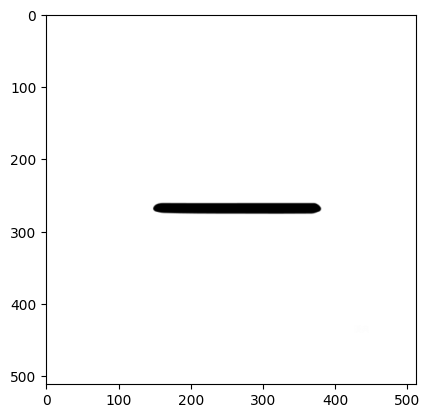

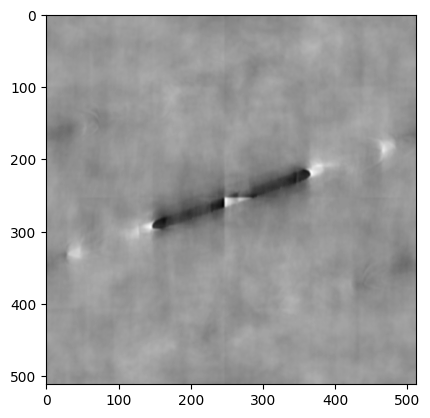

In [29]:
img = load_image('13_1')
print(img.shape)

effect_img = add_effects(img)

plt.imshow(img, cmap='gray')
plt.show()

plt.imshow(effect_img, cmap='gray')
plt.show()

In [3]:
name = "111_1.png"
name[name.index("_")+1:name.index(".")]

'1'